# Satellite classification via fine-tuning with EfficientNet

**Author:** [Praveen Manikonda]
**Description:** Use EfficientNet with weights pre-trained on imagenet for Satellite classification.

## Introduction: what is EfficientNet

EfficientNet, first introduced in [Tan and Le, 2019](https://arxiv.org/abs/1905.11946)
is among the most efficient models (i.e. requiring least FLOPS for inference)
that reaches State-of-the-Art accuracy on both
imagenet and common image classification transfer learning tasks.

A summary of the latest updates on the model is available at
[here](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet), where various
augmentation schemes and semi-supervised learning approaches are applied to further
improve the imagenet performance of the models. These extensions of the model can be used
by updating weights without changing model architecture.

## B0 to B7 variants of EfficientNet

*(This section provides some details on "compound scaling", and can be skipped
if you're only interested in using the models)*

Based on the [original paper](https://arxiv.org/abs/1905.11946) people may have the
impression that EfficientNet is a continuous family of models created by arbitrarily
choosing scaling factor in as Eq.(3) of the paper.  However, choice of resolution,
depth and width are also restricted by many factors:

- Resolution: Resolutions not divisible by 8, 16, etc. cause zero-padding near boundaries
of some layers which wastes computational resources. This especially applies to smaller
variants of the model, hence the input resolution for B0 and B1 are chosen as 224 and
240.

- Depth and width: The building blocks of EfficientNet demands channel size to be
multiples of 8.

- Resource limit: Memory limitation may bottleneck resolution when depth
and width can still increase. In such a situation, increasing depth and/or
width but keep resolution can still improve performance.

As a result, the depth, width and resolution of each variant of the EfficientNet models
are hand-picked and proven to produce good results, though they may be significantly
off from the compound scaling formula.
Therefore, the keras implementation (detailed below) only provide these 8 models, B0 to B7,
instead of allowing arbitray choice of width / depth / resolution parameters.

## Keras implementation of EfficientNet

An implementation of EfficientNet B0 to B7 has been shipped with tf.keras since TF2.3. To
use EfficientNetB0 for classifying 1000 classes of images from imagenet, run:

```python
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')
```

This model takes input images of shape (224, 224, 3), and the input data should range
[0, 255]. Normalization is included as part of the model.

Because training EfficientNet on ImageNet takes a tremendous amount of resources and
several techniques that are not a part of the model architecture itself. Hence the Keras
implementation by default loads pre-trained weights obtained via training with
[AutoAugment](https://arxiv.org/abs/1805.09501).

For B0 to B7 base models, the input shapes are different. Here is a list of input shape
expected for each model:

| Base model | resolution|
|----------------|-----|
| EfficientNetB0 | 224 |
| EfficientNetB1 | 240 |
| EfficientNetB2 | 260 |
| EfficientNetB3 | 300 |
| EfficientNetB4 | 380 |
| EfficientNetB5 | 456 |
| EfficientNetB6 | 528 |
| EfficientNetB7 | 600 |

When the model is intended for transfer learning, the Keras implementation
provides a option to remove the top layers:
```
model = EfficientNetB0(include_top=False, weights='imagenet')
```
This option excludes the final `Dense` layer that turns 1280 features on the penultimate
layer into prediction of the 1000 ImageNet classes. Replacing the top layer with custom
layers allows using EfficientNet as a feature extractor in a transfer learning workflow.

Another argument in the model constructor worth noticing is `drop_connect_rate` which controls
the dropout rate responsible for [stochastic depth](https://arxiv.org/abs/1603.09382).
This parameter serves as a toggle for extra regularization in finetuning, but does not
affect loaded weights. For example, when stronger regularization is desired, try:

```python
model = EfficientNetB0(weights='imagenet', drop_connect_rate=0.4)
```
The default value is 0.2.



## Setup and data loading

This example requires TensorFlow 2.3 or above.

To use TPU, the TPU runtime must match current running TensorFlow
version. If there is a mismatch, try:

```python
from cloud_tpu_client import Client
c = Client()
c.configure_tpu_version(tf.__version__, restart_type="always")
```

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()


2.4.1
Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [ ]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Data Collection

We've collected all the data and split them into train, test and validation using 70,15,15 percentages and kept them under folders of fire and nofire for the positive and negative examples of images having fire and no fire. 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
NUM_CLASSES=2

In [ ]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


base_dir = os.path.join(os.path.dirname('/content/gdrive/My Drive/'), 'satellite_images')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
print(train_dir)
train_fire_dir = os.path.join(train_dir, 'fire')  # directory with fire pictures
print(train_fire_dir)
train_nofire_dir = os.path.join(train_dir, 'nofire')  # directory with no-fire pictures
validation_fire_dir = os.path.join(validation_dir, 'fire')  # directory with ofire pictures
validation_nofire_dir = os.path.join(validation_dir, 'nofire')  # directory with no-fire pictures
test_fire_dir = os.path.join(test_dir, 'fire')
test_nofire_dir = os.path.join(test_dir, 'nofire')
print(train_nofire_dir)


/content/gdrive/My Drive/satellite_images/train
/content/gdrive/My Drive/satellite_images/train/fire
/content/gdrive/My Drive/satellite_images/train/nofire


In [ ]:
num_fire_tr = len(os.listdir(train_fire_dir))
num_nofire_tr = len(os.listdir(train_nofire_dir))

num_fire_val = len(os.listdir(validation_fire_dir))
num_nofire_val = len(os.listdir(validation_nofire_dir))
num_fire_test = len(os.listdir(test_fire_dir))
num_nofire_test = len(os.listdir(test_nofire_dir))

total_train = num_fire_tr + num_nofire_tr
total_val = num_fire_val + num_nofire_val
total_test = num_fire_test + num_nofire_test

# Data Statistics
In this section we will show basic data stats and some sample training set images. 

In [ ]:
print('total training fire images:', num_fire_tr)
print('total training nofire images:', num_nofire_tr)

print('total validation fire images:', num_fire_val)
print('total validation nofire images:', num_nofire_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total Test Images:", total_test)

total training fire images: 72
total training nofire images: 59
total validation fire images: 19
total validation nofire images: 24
--
Total training images: 131
Total validation images: 43
Total Test Images: 61


In [ ]:
BATCH_SIZE = 100 # Number of training examples to process before updating our models variables
IMG_SHAPE  = 224  # Our training data consists of images with width of 150 pixels and height of 150 pixels

In [ ]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our test data

In [ ]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )


train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                           class_mode='binary')

Found 131 images belonging to 2 classes.


In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE),
                                                              class_mode='binary')

Found 42 images belonging to 2 classes.


In [ ]:
test_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=test_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                           class_mode='binary')

Found 60 images belonging to 2 classes.


In [ ]:
sample_training_images, _ = next(train_data_gen)

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

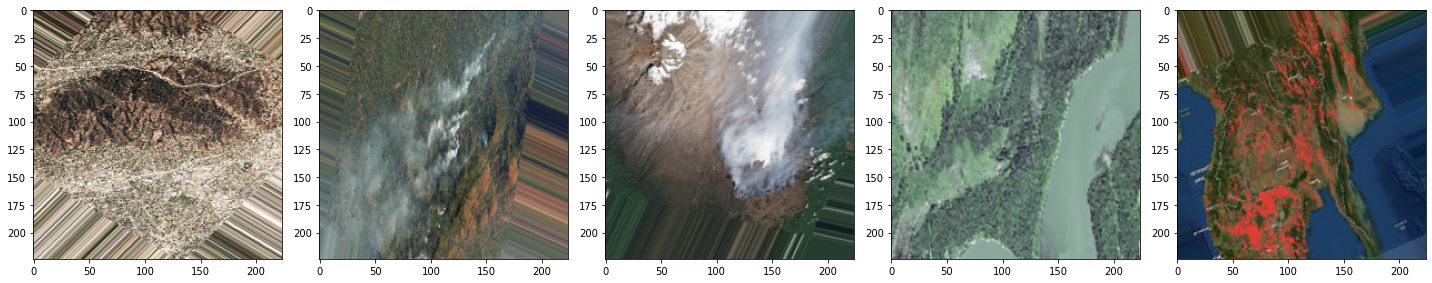

In [ ]:
plotImages(sample_training_images[0:10])  

## Training a model from scratch

We build an EfficientNetB0 with 120 output classes, that is initialized from scratch:

Note: the accuracy will increase very slowly and may overfit.

In [ ]:
IMG_SIZE=224

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [ ]:
# for image, label in ds_train.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         aug_img = img_augmentation(tf.expand_dims(image, axis=0))
#         plt.imshow(aug_img[0].numpy().astype("uint8"))
#         plt.title("{}".format(format_label(label)))
#         plt.axis("off")


NameError: ignored

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x)

    # Freeze the pretrained weights
    model.trainable = False

    # # Rebuild top
    # x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

model.summary()

epochs = 40  # @param {type: "slider", min:10, max:100}
hist = model.fit(train_data_gen, epochs=epochs, validation_data=val_data_gen, verbose=2)


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
top_dropout (Dropout)        (None, 224, 224, 3)       0         
_________________________________________________________________
pred (Dense)                 (None, 224, 224, 2)       8         
Total params: 20
Trainable params: 14
Non-trainable params: 6
_________________________________________________________________
Epoch 1/40
INFO:tensorflow:Error reported to Coordinator: Shapes (None, 1) and (None, 224, 224, 2) are incompatible
Traceback (mo

ValueError: ignored

Training the model is relatively fast (takes only 20 seconds per epoch on TPUv2 that is
available on Colab). This might make it sounds easy to simply train EfficientNet on any
dataset wanted from scratch. However, training EfficientNet on smaller datasets,
especially those with lower resolution like CIFAR-100, faces the significant challenge of
overfitting.

Hence training from scratch requires very careful choice of hyperparameters and is
difficult to find suitable regularization. It would also be much more demanding in resources.
Plotting the training and validation accuracy
makes it clear that validation accuracy stagnates at a low value.

In [ ]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

## Transfer learning from pre-trained weights

Here we initialize the model with pre-trained ImageNet weights,
and we fine-tune it on our own dataset.

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing


def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


The first step to transfer learning is to freeze all layers and train only the top
layers. For this step, a relatively large learning rate (1e-2) can be used.
Note that validation accuracy and loss will usually be better than training
accuracy and loss. This is because the regularization is strong, which only
suppresses training-time metrics.

Note that the convergence may take up to 50 epochs depending on choice of learning rate.
If image augmentation layers were not
applied, the validation accuracy may only reach ~60%.

In [ ]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)

epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(train_data_gen, epochs=epochs, validation_data=val_data_gen, verbose=2)
plot_hist(hist)

The second step is to unfreeze a number of layers and fit the model using smaller
learning rate. In this example we show unfreezing all layers, but depending on
specific dataset it may be desireble to only unfreeze a fraction of all layers.

When the feature extraction with
pretrained model works good enough, this step would give a very limited gain on
validation accuracy. In our case we only see a small improvement,
as ImageNet pretraining already exposed the model to a good amount of dogs.

On the other hand, when we use pretrained weights on a dataset that is more different
from ImageNet, this fine-tuning step can be crucial as the feature extractor also
needs to be adjusted by a considerable amount. Such a situation can be demonstrated
if choosing CIFAR-100 dataset instead, where fine-tuning boosts validation accuracy
by about 10% to pass 80% on `EfficientNetB0`.
In such a case the convergence may take more than 50 epochs.

A side note on freezing/unfreezing models: setting `trainable` of a `Model` will
simultaneously set all layers belonging to the `Model` to the same `trainable`
attribute. Each layer is trainable only if both the layer itself and the model
containing it are trainable. Hence when we need to partially freeze/unfreeze
a model, we need to make sure the `trainable` attribute of the model is set
to `True`.

In [ ]:

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 10  # @param {type: "slider", min:8, max:50}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)